# Scikit-learn applied to mouse input detection

Aplying simpler models from scikit-learn 

In [1]:
# Serialization
import pickle

# Numbers
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
sns.set(color_codes=True)
from matplotlib import pyplot as plt
%matplotlib inline

# Machine learning
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import TimeSeriesSplit

# 1. data loading:
- Deserialize dataset
- Convert to Pandas dataframe

In [2]:
flocal = open('local.pkl','rb')
local_data = pickle.load(flocal)
flocal.close()

fremote = open('remote.pkl','rb')
remote_data = pickle.load(fremote)
fremote.close()

fother_local = open('other_local.pkl','rb')
other_data = pickle.load(fother_local)
fother_local.close()

In [3]:
df_local = pd.DataFrame(local_data['x'][:,:])
df_local['origin'] = 'USER0_LOCAL'

df_remote = pd.DataFrame(remote_data['x'][:,:])
df_remote['origin'] = 'USER0_REMOTE'

df_remote_user1 = pd.DataFrame(other_data['x'][:,:])
df_remote_user1 = df_remote_user1[df_remote_user1[2] == 'MOUSE_MOVE']
df_remote_user1['origin'] = 'USER1_LOCAL'

df = pd.concat([df_local, df_remote, df_remote_user1])
df.columns = ['dt', 'device', 'event_type', 'x', 'y', 'origin']
df['dt'] = pd.to_numeric(df['dt'])
df['x'] = pd.to_numeric(df['x'])
df['y'] = pd.to_numeric(df['y'])


# 2. data exploration:
- Explore data: statistics & visualization

In [4]:
df.head()

,dt,device,event_type,x,y,origin
0,0.000000,MOUSE,MOUSE_MOVE,969,569,USER0_LOCAL
1,0.008815,MOUSE,MOUSE_MOVE,967,565,USER0_LOCAL
2,0.007102,MOUSE,MOUSE_MOVE,963,555,USER0_LOCAL
3,0.008023,MOUSE,MOUSE_MOVE,956,544,USER0_LOCAL
4,0.008282,MOUSE,MOUSE_MOVE,949,534,USER0_LOCAL


In [5]:
def print_stats(df, colname, origin):
    col = df[colname][df.origin == origin]
    print('{:3} => {:12}: mean:{:10.3f}    variance:{:10.3f}  std:{:10.3f}  min:{:10.3f}  max:{:10.3f}'.format(
        colname, origin, np.mean(col), np.var(col), np.std(col), np.min(col), np.max(col)))

print_stats(df, 'dt', 'USER0_LOCAL')
print_stats(df, 'dt', 'USER1_LOCAL')
print_stats(df, 'dt', 'USER0_REMOTE')
print()
print_stats(df, 'x', 'USER0_LOCAL')
print_stats(df, 'x', 'USER1_LOCAL')
print_stats(df, 'x', 'USER0_REMOTE')
print()
print_stats(df, 'y', 'USER0_LOCAL')
print_stats(df, 'y', 'USER1_LOCAL')
print_stats(df, 'y', 'USER0_REMOTE')


dt  => USER0_LOCAL : mean:     0.062    variance:     0.375  std:     0.612  min:     0.000  max:    37.408
dt  => USER1_LOCAL : mean:     0.060    variance:     0.832  std:     0.912  min:     0.000  max:    86.697
dt  => USER0_REMOTE: mean:     0.150    variance:     7.696  std:     2.774  min:     0.000  max:   161.172

x   => USER0_LOCAL : mean:   587.827    variance:102130.459  std:   319.579  min:     0.000  max:  1365.000
x   => USER1_LOCAL : mean:   760.954    variance:145445.071  std:   381.373  min:     0.000  max:  1365.000
x   => USER0_REMOTE: mean:   501.994    variance: 94343.115  std:   307.153  min:     0.000  max:  1365.000

y   => USER0_LOCAL : mean:   338.935    variance: 38249.973  std:   195.576  min:     0.000  max:   767.000
y   => USER1_LOCAL : mean:   435.187    variance: 39270.740  std:   198.168  min:     0.000  max:   767.000
y   => USER0_REMOTE: mean:   345.129    variance: 34389.622  std:   185.444  min:     0.000  max:   767.000


/home/ubuntu/data/installs/miniconda3/envs/dl-python35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


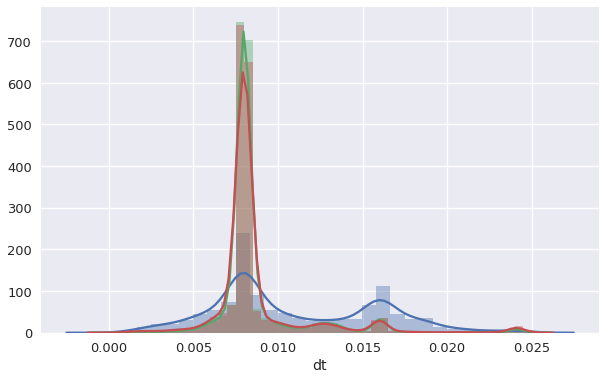

In [6]:
sns.set_context("talk")
plt.figure(figsize=(10, 6))
sns.distplot(df.query('dt < 0.025 and origin == \'USER0_REMOTE\'')['dt'])
sns.distplot(df.query('dt < 0.025 and origin == \'USER0_LOCAL\'')['dt'])
sns.distplot(df.query('dt < 0.025 and origin == \'USER1_LOCAL\'')['dt'])


/home/ubuntu/data/installs/miniconda3/envs/dl-python35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


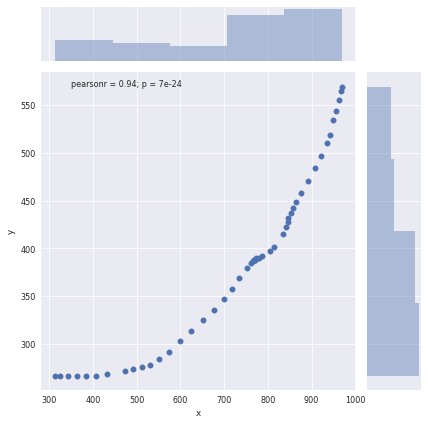

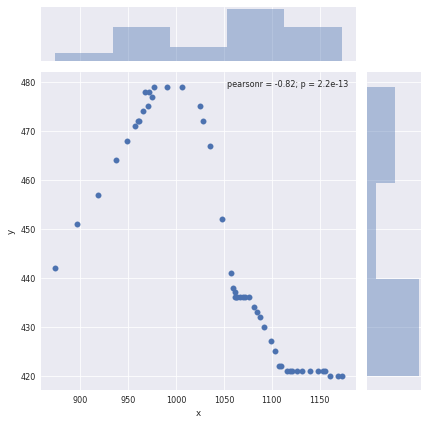

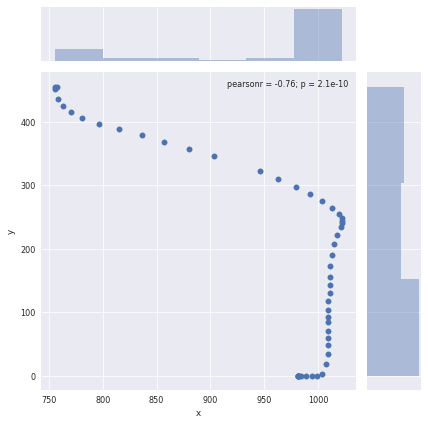

In [7]:
sns.set_context("paper")
sns.jointplot(x="x", y="y", data=df.query('origin == \'USER0_LOCAL\'')[0:50]);
sns.jointplot(x="x", y="y", data=df.query('origin == \'USER0_REMOTE\'')[0:50]);
sns.jointplot(x="x", y="y", data=df.query('origin == \'USER1_LOCAL\'')[0:50]);


# 3. data preprocessing for ML:
- Remove unused data
- Format data for machine learning: standardization and normalization, label encoding
- Create labeled subsequences
- Split dataset on training and testing sets

In [31]:
# Drop unused columns
df_dts = df.drop(['device', 'event_type', 'x', 'y'], 1)

# Numerical encoding for labels
label_encoder = LabelEncoder()
df_dts['origin'] = label_encoder.fit_transform(df_dts['origin'])

labels = label_encoder.inverse_transform([0, 1, 2])
print('Label encoding: 0 -> {} , 1 -> {}, 2 -> {}'.format(labels[0], labels[1], labels[2]))

# Remove outliers
df_dts = df_dts[df.dt < df.dt.quantile(.95)]

# Give 0 mean and unit variance to data
standard_scaler = StandardScaler()
df_dts['dt'] = standard_scaler.fit_transform(df_dts['dt'].values.reshape(-1, 1))

Label encoding: 0 -> USER0_LOCAL , 1 -> USER0_REMOTE, 2 -> USER1_LOCAL


In [32]:
# Create labeled subsequences
# (All categories must have the same number of examples)
min_len = np.min([len(df_dts[df_dts.origin == 0]), len(df_dts[df_dts.origin == 1]), len(df_dts[df_dts.origin == 2])])
seq_size = 50
num_examples = min_len // seq_size

class0 = df_dts[df_dts.origin == 0][:num_examples * seq_size]['dt']
class1 = df_dts[df_dts.origin == 1][:num_examples * seq_size]['dt']
class2 = df_dts[df_dts.origin == 2][:num_examples * seq_size]['dt']

class0_x = np.hsplit(class0, num_examples)
class1_x = np.hsplit(class1, num_examples)
class2_x = np.hsplit(class2, num_examples)

class0_y = np.full(num_examples, 0, dtype=np.float32)
class1_y = np.full(num_examples, 1, dtype=np.float32)
class2_y = np.full(num_examples, 2, dtype=np.float32)

x = np.vstack([class0_x, class1_x])
y = np.append(class0_y, class1_y)

# Random permutation of all the examples
permutation = np.random.permutation(len(y))
y = y[permutation]
x = x[permutation]

In [33]:
clf = LogisticRegression()
scores = cross_val_score(clf, x, y, cv=20)
np.mean(scores)

0.63794642857142858

In [34]:
clf = DecisionTreeClassifier(max_depth=2)
scores = cross_val_score(clf, x, y, cv=20)
np.mean(scores)

0.73258928571428572

In [35]:
clf = AdaBoostClassifier(n_estimators=300)
scores = cross_val_score(clf, x, y, cv=20)
np.mean(scores)

0.93973214285714268

/home/ubuntu/data/installs/miniconda3/envs/dl-python35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


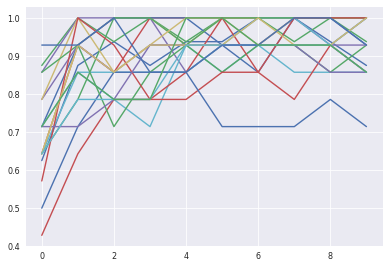

In [36]:
clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=2), 
    n_estimators=300)

_, train_scores, test_scores = learning_curve(clf, x, y, 
                                              cv = 5, 
                                              train_sizes=np.linspace(0.1, 1.0, 10))

plt.plot(test_scores)

# Tests con features x e y

In [38]:
df_pos = df.copy()

# Numerical encoding for labels
label_encoder = LabelEncoder()
df_pos['origin'] = label_encoder.fit_transform(df_pos['origin'])

labels = label_encoder.inverse_transform([0, 1, 2])
print('Label encoding: 0 -> {} , 1 -> {}, 2 -> {}'.format(labels[0], labels[1], labels[2]))

# Remove outliers (no outliers in position data)
df_pos = df_pos[df_pos.dt < df_pos.dt.quantile(.95)]

# Give 0 mean and unit variance to data
standard_scaler = StandardScaler()
df_pos['x'] = standard_scaler.fit_transform(df_pos['x'].values.reshape(-1, 1))
df_pos['y'] = standard_scaler.fit_transform(df_pos['y'].values.reshape(-1, 1))
df_pos['dt'] = standard_scaler.fit_transform(df_pos['dt'].values.reshape(-1, 1))

Label encoding: 0 -> USER0_LOCAL , 1 -> USER0_REMOTE, 2 -> USER1_LOCAL


/home/ubuntu/data/installs/miniconda3/envs/dl-python35/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [39]:
# Create labeled subsequences
# (All categories must have the same number of examples)
min_len = np.min([len(df_pos[df_pos.origin == 0]), len(df_pos[df_pos.origin == 1]), len(df_pos[df_pos.origin == 2])])
seq_size = 70
num_examples = min_len // seq_size

class0 = df_pos[df_pos.origin == 0][:num_examples * seq_size][['x', 'y', 'dt']].values
class1 = df_pos[df_pos.origin == 1][:num_examples * seq_size][['x', 'y', 'dt']].values
class2 = df_pos[df_pos.origin == 2][:num_examples * seq_size][['x', 'y', 'dt']].values

class0_x = np.vsplit(class0, num_examples)
class1_x = np.vsplit(class1, num_examples)
class2_x = np.vsplit(class2, num_examples)
class0_x = [ arr.reshape(seq_size*3) for arr in class0_x ]
class1_x = [ arr.reshape(seq_size*3) for arr in class1_x ]
class2_x = [ arr.reshape(seq_size*3) for arr in class2_x ]

class0_y = np.full(num_examples, 0, dtype=np.float32)
class1_y = np.full(num_examples, 1, dtype=np.float32)
class2_y = np.full(num_examples, 2, dtype=np.float32)


x = np.concatenate([class0_x, class2_x], axis=0)
# x = np.concatenate(x, axis=2)
y = np.append(class0_y, class2_y)

# Random permutation of all the examples
permutation = np.random.permutation(len(y))
y = y[permutation]
x = x[permutation]

In [40]:
x.shape

(202, 210)

In [29]:
clf = AdaBoostClassifier(n_estimators=300)
scores = cross_val_score(clf, x, y, cv=20)
np.mean(scores)

0.79083333333333339

/home/ubuntu/data/installs/miniconda3/envs/dl-python35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


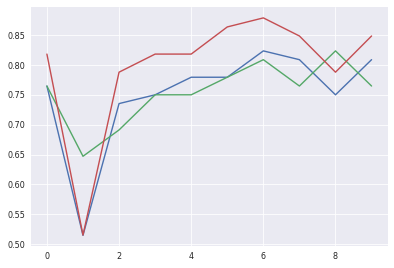

In [41]:
clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=2), 
    n_estimators=100)

_, train_scores, test_scores = learning_curve(clf, x, y, 
                                              cv = 3, 
                                              train_sizes=np.linspace(0.1, 1.0, 10))

plt.plot(test_scores)